# Reconstrução 3D

## Setup do notebook

In [1]:
import sys
import os

from canon.utils import image_utils
from canon.T2.process import feature_extraction, epipolar_geometry
from canon.T2.plotting import visualization

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

print("Módulos importados com sucesso!")

Módulos importados com sucesso!


In [2]:
# Configurações
SELECTED_OBJECT = "msc_grandiosa_miniatura"  # Mudar para extrair características de outro objeto
MAX_PAIRS = None # Limitar número de pares para teste inicial
MIN_MATCHES = 30  # Mínimo de matches por par

In [3]:
# Carregar imagens
images = image_utils.load_images(f"T2/interim/{SELECTED_OBJECT}")
print(f"Carregadas {len(images)} imagens")

# Carregar características SIFT da Etapa 2
features_path = f"../../data/T2/interim/{SELECTED_OBJECT}/orb_features.pkl"

try:
    with open(features_path, 'rb') as f:
        saved_features = pickle.load(f)
    print(f"Características carregadas de: {features_path}")
    print(f"Características disponíveis para {len(saved_features)} imagens")
except FileNotFoundError:
    print(f"Arquivo de características não encontrado: {features_path}")
    print("Execute primeiro o notebook S2-1.0-hpbv-feature-extraction.ipynb")
    saved_features = None

Carregadas 100 imagens
Arquivo de características não encontrado: ../../data/T2/interim/msc_grandiosa_miniatura/orb_features.pkl
Execute primeiro o notebook S2-1.0-hpbv-feature-extraction.ipynb


In [4]:
# Reconstrói keypoints do formato salvo
def reconstruct_keypoints(kp_data):
    keypoints = []
    for pt, angle, size, response in kp_data:
        kp = cv2.KeyPoint(x=pt[0], y=pt[1], size=size, angle=angle, response=response)
        keypoints.append(kp)
    return keypoints

# Reconstrói features no formato esperado
if saved_features is not None:
    features = {}
    for img_name, data in saved_features.items():
        keypoints = reconstruct_keypoints(data['keypoints_data'])
        descriptors = data['descriptors']
        features[img_name] = (keypoints, descriptors)
    
    print(f"Características reconstruídas para {len(features)} imagens")
else:
    print("Extraindo características novamente...")
    # Fallback: extrai características novamente
    features_data = feature_extraction.extract_sift_for_3d(
        images, save_visualizations=False
    )
    features = {name: (data['keypoints'], data['descriptors']) 
               for name, data in features_data.items()}

Extraindo características novamente...
Extracting SIFT features from 100 images...


Processing SIFT metadata: 100%|██████████| 100/100 [00:00<00:00, 620459.17image/s]


In [5]:
# Configura matcher
matcher = epipolar_geometry.ImagePairMatcher(
    matcher_type="BF",  # Brute Force
    ratio_threshold=0.75,
    cross_check=False  # Desabilitado para usar ratio test
)

print("Matcher configurado: Brute Force com Lowe's ratio test (0.75)")

Matcher configurado: Brute Force com Lowe's ratio test (0.75)


In [6]:
# Realiza emparelhamento
print("Iniciando emparelhamento...")

match_results = epipolar_geometry.match_image_collection(
    features=features,
    matcher=matcher,
    max_pairs=None,
    min_matches=MIN_MATCHES
)

print(f"\nEmparelhamento concluído!")
print(f"Pares bem-sucedidos: {len(match_results)}")

Iniciando emparelhamento...
Matching 4950 image pairs...


Matching pairs: 100%|██████████| 4950/4950 [01:02<00:00, 79.71pair/s]

Successfully matched 4950/4950 pairs

Emparelhamento concluído!
Pares bem-sucedidos: 4950


In [7]:
# Cria visualizações dos melhores pares
visualization.visualize_matching_results(
    match_results=match_results,
    images=images,
    save_pairs=5,  # 5 melhores pares
    save_path=f"T2/interim/{SELECTED_OBJECT}/S3-hpbv-feature-matching"
)

# Cria gráfico resumo
visualization.create_matching_summary_plot(
    match_results,
    save_path=f"../../data/T2/interim/{SELECTED_OBJECT}/S3-hpbv-feature-matching/matching_summary.png"
)

Saving match visualizations: 100%|██████████| 5/5 [00:00<00:00, 26.74pair/s]


Saved match visualization: matches_1_2_1351matches
Saved match visualization: matches_2_3_1335matches
Saved match visualization: matches_98_99_1330matches
Saved match visualization: matches_4_5_1312matches
Saved match visualization: matches_3_4_1294matches
Matching summary saved to ../../data/T2/interim/msc_grandiosa_miniatura/S3-hpbv-feature-matching/matching_summary.png

Matching Statistics:
Total pairs processed: 4950
Average matches per pair: 223.5
Median matches per pair: 145.0
Max matches: 1351
Min matches: 38


In [ ]:
# Configura estimador de geometria epipolar
# Para início, assumimos câmera não calibrada (apenas matriz fundamental)

sample_img = list(images.values())[0]
K = epipolar_geometry.estimate_epipolar_matrix(sample_img)

print(f"Matriz de câmera estimada:")
print(K)

# Cria estimador
epipolar_estimator = epipolar_geometry.EpipolarGeometryEstimator(
    camera_matrix=K,  # Começa sem calibração
    ransac_threshold=1.0,
    confidence=0.99
)

print("Estimador configurado para matriz fundamental (calibrada)")

Matriz de câmera estimada:
[[1.28e+03 0.00e+00 3.60e+02]
 [0.00e+00 1.28e+03 6.40e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
Resolução da imagem: 720x1280
Estimador configurado para matriz fundamental (calibrada)


In [9]:
# Escolher um par inicial (o que tiver mais matches)
best_pair = max(match_results.items(), key=lambda x: x[1]['num_matches'])
(img1, img2), match_data = best_pair

pts1, pts2 = match_data['pts1'], match_data['pts2']

E, mask = epipolar_estimator.estimate_essential_matrix(pts1, pts2)
_, R, t, tri_mask = epipolar_estimator.recover_pose(E, pts1, pts2, mask)

In [10]:
triangulator = epipolar_geometry.Triangulator(K)
R1, t1 = np.eye(3), np.zeros((3,1))   # câmera 1 como referência
R2, t2 = R, t
pts_4d = triangulator.triangulate_points(pts1, pts2, R1, t1, R2, t2)
pts_3d = triangulator.convert_to_3d(pts_4d)

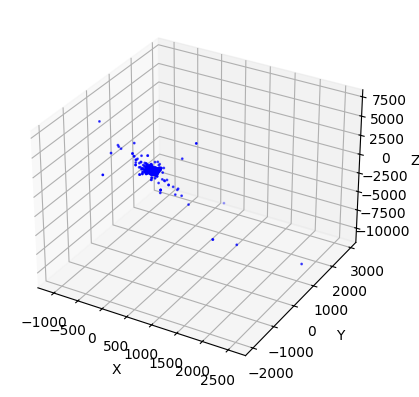

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Exemplo: pts_3d é um array Nx3 vindo do Triangulator
#pts_3d = np.random.rand(100, 3)  # substitua pelos seus pontos

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_3d[:, 0], pts_3d[:, 1], pts_3d[:, 2], s=1, c='b')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [12]:
def filter_points_by_reprojection(points_3d, image_points, R, t, K, reproj_thresh=3.0):
    """
    Remove pontos 3D cujo erro de reprojeção é maior que o limite.
    
    Args:
        points_3d: (N,3) pontos reconstruídos.
        image_points: (N,2) pontos 2D correspondentes.
        R, t: pose da câmera.
        K: matriz intrínseca da câmera.
        reproj_thresh: limite em pixels para considerar inlier.
    
    Returns:
        inliers_3d: pontos 3D filtrados.
        mask: array booleano indicando quais pontos foram mantidos.
    """
    proj_points, _ = cv2.projectPoints(points_3d, cv2.Rodrigues(R)[0], t, K, None)
    proj_points = proj_points.reshape(-1, 2)
    
    errors = np.linalg.norm(proj_points - image_points, axis=1)
    mask = errors < reproj_thresh
    return points_3d[mask], mask


In [44]:
# --- Passo 2: adicionar novas imagens ---
used_images = {img1, img2}
remaining_images = set(features.keys()) - used_images



In [ ]:
global_points = []

def register_new_image(img, features, match_results, cameras, used_images, global_points, K):
    """
    Registra uma nova imagem no SfM incremental:
    - Busca correspondências 2D–3D
    - Estima pose com solvePnPRansac
    - Triangula novos pontos com uma imagem de referência
    - Atualiza a nuvem global
    
    Retorna True se a imagem foi registrada com sucesso.
    """
    print(f"\n>> Registrando imagem {img}")

    # Procurar matches com imagens já registradas
    all_matches = []
    for ref_img in used_images:
        key = (ref_img, img) if (ref_img, img) in match_results else (img, ref_img)
        if key in match_results:
            all_matches.append((ref_img, match_results[key], key))
    
    if not all_matches:
        print("Sem matches suficientes, pulando...")
        return False

    # Escolher referência com mais matches
    ref_img, match_data, key = max(all_matches, key=lambda x: x[1]['num_matches'])
    kp_ref, _ = features[ref_img]
    kp_new, _ = features[img]

    pts_ref = match_data['pts1'] if ref_img == key[0] else match_data['pts2']
    pts_new = match_data['pts2'] if ref_img == key[0] else match_data['pts1']

    object_points = np.array(global_points[:len(pts_new)], dtype=np.float32) # fake associações 
    image_points = pts_new[:len(object_points)].reshape(-1,2)

    # object_points = np.array(object_points, dtype=np.float32)
    # image_points = np.array(image_points, dtype=np.float32)

    if len(object_points) < 6:
        print("Poucos pontos 2D-3D, pulando...")
        return False

    # --- Estimar pose com PnP robusto ---
    success, rvec, tvec = cv2.solvePnP(
        object_points, image_points, K, None
        # iterationsCount=2000,
        # reprojectionError=8.0,
        # confidence=0.999
    )
    if not success:
        print("PnP falhou, pulando...")
        return False

    R_new, _ = cv2.Rodrigues(rvec)
    t_new = tvec
    cameras[img] = (R_new, t_new)
    used_images.add(img)

    # --- Triangular novos pontos com a referência ---
    pts_4d = triangulator.triangulate_points(
        pts_ref, pts_new,
        cameras[ref_img][0], cameras[ref_img][1],
        R_new, t_new
    )
    new_points_3d = triangulator.convert_to_3d(pts_4d)

    # Filtrar por reprojeção
    new_points_3d = np.array(new_points_3d, dtype=np.float32)
    image_points_new = pts_new.reshape(-1, 2)[:len(new_points_3d)]

    inliers_3d, mask = filter_points_by_reprojection(
        new_points_3d, image_points_new, R_new, t_new, K, reproj_thresh=5.0
    )

    print(f"Triangulados {len(new_points_3d)} pontos, mantidos {len(inliers_3d)} inliers")

    global_points.extend(inliers_3d.tolist())

    return True


In [63]:
# Inicializar câmeras
cameras = {
    img1: (np.eye(3), np.zeros((3,1))),  # identidade
    img2: (R, t)
}

# Triangular pontos iniciais
pts_4d = triangulator.triangulate_points(pts1, pts2,
                                            cameras[img1][0], cameras[img1][1],
                                            cameras[img2][0], cameras[img2][1])
points_3d = triangulator.convert_to_3d(pts_4d).tolist()

# --- Passo 2: adicionar novas imagens ---
used_images = {img1, img2}
remaining_images = set(features.keys()) - used_images

# global_points  = []

for img in remaining_images:
    success = register_new_image(
        img=img,
        features=features,
        match_results=match_results,
        cameras=cameras,
        used_images=used_images,
        global_points=points_3d,
        K=K
    )
    if success:
        print(f"Imagem {img} registrada com sucesso!")
    else:
        print(f"Imagem {img} não pôde ser registrada.")


>> Registrando imagem 58
Triangulados 190 pontos, mantidos 4 inliers
Imagem 58 registrada com sucesso!

>> Registrando imagem 61
Triangulados 835 pontos, mantidos 7 inliers
Imagem 61 registrada com sucesso!

>> Registrando imagem 90
Triangulados 255 pontos, mantidos 3 inliers
Imagem 90 registrada com sucesso!

>> Registrando imagem 4
Triangulados 1208 pontos, mantidos 4 inliers
Imagem 4 registrada com sucesso!

>> Registrando imagem 69
Triangulados 163 pontos, mantidos 0 inliers
Imagem 69 registrada com sucesso!

>> Registrando imagem 40
Triangulados 202 pontos, mantidos 0 inliers
Imagem 40 registrada com sucesso!

>> Registrando imagem 24
Triangulados 167 pontos, mantidos 1 inliers
Imagem 24 registrada com sucesso!

>> Registrando imagem 13
Triangulados 533 pontos, mantidos 8 inliers
Imagem 13 registrada com sucesso!

>> Registrando imagem 26
Triangulados 869 pontos, mantidos 24 inliers
Imagem 26 registrada com sucesso!

>> Registrando imagem 27
Triangulados 916 pontos, mantidos 16 i

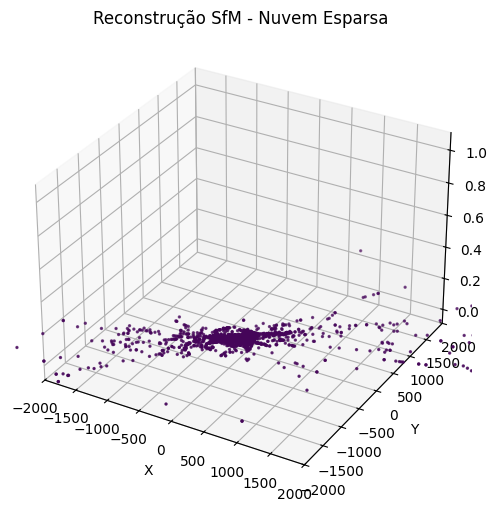

In [64]:
def plot_point_cloud(points, title="Point Cloud"):
    """
    Plota uma nuvem de pontos 3D com matplotlib.

    Args:
        points: array (N, 3) contendo pontos [x, y, z].
    """
    if isinstance(points, list):
        points = np.array(points)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(points[:, 0], points[:, 1], points[:, 2],
               c=points[:, 2], cmap="viridis", s=2)

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    plt.xlim((-2000,2000))
    
    plt.ylim((-2000,2000))
    plt.show()

# Exemplo de uso:
# cloud = np.array(points_3d)  # vindo do incremental_sfm
plot_point_cloud(points_3d, title="Reconstrução SfM - Nuvem Esparsa")